In [268]:
# Libraries
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from IPython.core.interactiveshell import InteractiveShell

# Notebook Settings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read data
This is harvested area and yield by municipality 

In [269]:
ha = pd.read_csv("Data/Wheat/haaa.csv") # 1990-2016
yi = pd.read_csv("Data/Wheat/yiiiieeeeld.csv") # 1993-2016

### 2. Calculate National Wheat Yield
National wheat yield in year *j* is the weighted sum of yields of each municipality

$\frac{1}{\sum_{i=1}^{N}HarvestedArea_{ij}} * \sum_{i=1}^{N} HarvestedArea_{ij}*Yield_{ij}$

In [270]:
national_yield = pd.DataFrame((yi.set_index(["code", "zone"]) * ha.set_index(["code", "zone"])).sum() / ha.set_index(["code", "zone"]).sum(), columns=["yield"])
national_yield = np.round(national_yield.iloc[3:].reset_index().rename(columns={"index":"year"}), 2)
national_yield.head(2)

,year,yield
0,1993,1494.53
1,1994,1596.14


<AxesSubplot:xlabel='year'>

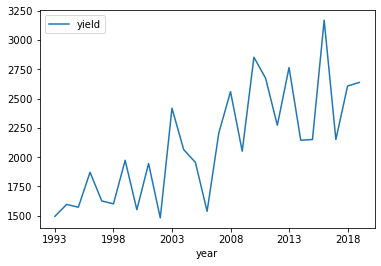

In [271]:
national_yield.plot("year", "yield")

### 3. Calculate Wheat Yield by Group

In [272]:
yield_by_group = (yi.set_index(["code", "zone"]) * ha.set_index(["code", "zone"])).groupby(["zone"]).sum() / ha.set_index(["code", "zone"]).groupby(["zone"]).sum()
yield_by_group = yield_by_group.stack().reset_index().rename({"level_1":"year", 0:"yield"}, axis=1)
yield_by_group = np.round(yield_by_group.loc[yield_by_group["year"].astype(int) >= 1993].reset_index(drop=True), 2)
yield_by_group.head(2)

,zone,year,yield
0,1,1993,1541.02
1,1,1994,1464.91


<AxesSubplot:xlabel='year', ylabel='yield'>

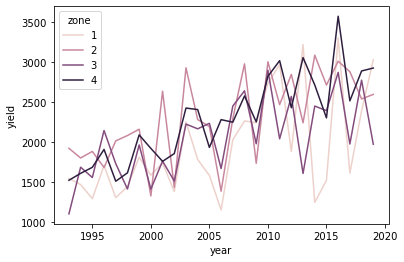

In [273]:
sns.lineplot(data=yield_by_group.astype(int), x="year", y="yield", hue="zone")

### 4. Detrend Wheat Yield Data

#### By Group

In [275]:
def detrend_yield_by_group(df):
    df = df.copy()
    li = []
    for group in [1, 2, 3, 4]:
        cv_yield = df.loc[(df["zone"] == group)].copy().reset_index(drop=True)
        reg = LinearRegression()
        slope_cv = reg.fit(cv_yield["year"].values.reshape(-1,1), cv_yield["yield"]).coef_[0]
        cv_yield["yield_detrended"] = cv_yield["yield"] + (slope_cv * (2019 - cv_yield["year"].astype(int)))
        #cv_yield["yield_detrended"] = cv_yield["yield_detrended"] - cv_yield["yield_detrended"].mean()
        li.append(cv_yield)

    df_cv = (pd
             .concat(li, axis=0, ignore_index=False)
             .sort_values(by=["zone", "year"])
             .reset_index(drop=True)
             .drop(["yield"], axis=1)
             .rename(columns={"yield_detrended":"yield"}))
        
    return df_cv

In [276]:
yield_by_group_detrended = detrend_yield_by_group(yield_by_group)

<AxesSubplot:xlabel='year', ylabel='yield'>

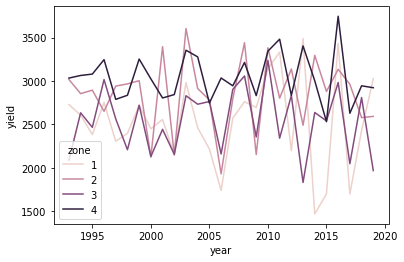

In [277]:
sns.lineplot(data=yield_by_group_detrended.astype(int), x="year", y="yield", hue="zone")

In [278]:
yield_by_group_detrended.to_csv("Data/Wheat/yield_by_group_detrended.csv", index=False)

#### National

In [279]:
def detrend_national_yield(df):
    df = df.copy()
    reg = LinearRegression()
    slope_cv = reg.fit(df["year"].values.reshape(-1,1), df["yield"]).coef_[0]

    df["yield_detrended"] = df["yield"] + (slope_cv * (2019 - df["year"].astype(int)))
    #df["yield_detrended"] = df["yield_detrended"] - df["yield_detrended"].mean()
    df = df.drop(["yield"], axis=1).rename(columns={"yield_detrended":"yield"})
    
    return df

In [280]:
national_yield_detrended = detrend_national_yield(national_yield)

<AxesSubplot:xlabel='year', ylabel='yield'>

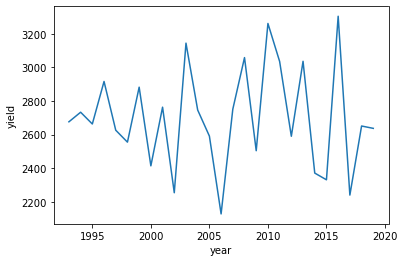

In [281]:
sns.lineplot(data=national_yield_detrended.astype(int), x="year", y="yield")

In [282]:
national_yield_detrended.to_csv("Data/Wheat/national_yield_detrended.csv", index=False)

### 5. Harvested Area

In [286]:
ha_grouped = ha.groupby("zone").sum().stack().reset_index().rename({"level_1":"year", 0:"area"}, axis=1).iloc[1:].reset_index(drop=True)
ha_grouped['relative area'] = ha_grouped['area'] / ha_grouped.groupby('year')['area'].transform('sum')
ha_grouped.head(2)

,zone,year,area,relative area
0,1,1990,1009412.0,0.435808
1,1,1991,674580.0,0.352521


#### Forward Validation

In [287]:
def forward_validation(df, previous_days=1):
    sum_ = 0
    for group in [1, 2, 3, 4]:
        sum_group = 0
        for i in range(3, 27):
            sum_group += abs(df.loc[df["zone"] == group, "relative area"].values[i-previous_days:i] 
                             - df.loc[df["zone"] == group, "relative area"].values[i])
        sum_group /= 24
        sum_ += sum_group[0]
    sum_ /= 4
    return sum_

In [288]:
forward_validation(ha_grouped, 1)
forward_validation(ha_grouped, 2)
forward_validation(ha_grouped, 3)

0.03509815566825231

0.05096479908330413

0.048025698292979355

In [289]:
ha_grouped["area"] = ha_grouped["relative area"].shift(1)
ha_grouped = np.round(ha_grouped.loc[ha_grouped["year"].isin(["code", '1990', '1991', '1992']) == False, ["zone", "year", "area"]].reset_index(drop=True), 2)
ha_grouped.head(5)

,zone,year,area
0,1,1993,0.31
1,1,1994,0.43
2,1,1995,0.43
3,1,1996,0.30
4,1,1997,0.33


<AxesSubplot:xlabel='year', ylabel='area'>

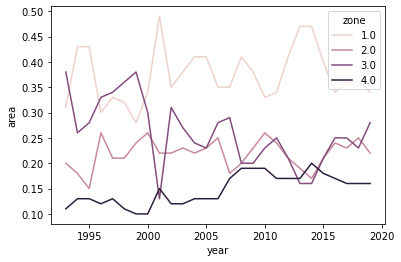

In [290]:
sns.lineplot(data=ha_grouped.astype(float), x="year", y="area", hue="zone")

In [291]:
ha_grouped.to_csv("Data/Wheat/harvested_area_estimates_by_group.csv", index=False)